# gorey 
## Telluric correction
### Part 4- Second epoch telluric correction: 20161013

Michael Gully-Santiago  
Tuesday, March 28, 2017

see this issue: https://github.com/igrins/plp/issues/19

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in the data.

The target frame is `_0230`, the A0V standard is either frame `_0226` or `_0238`... let's go with the latter.

In [3]:
!ls ../data/raw/20161013/*0230*

../data/raw/20161013/SDCH_20161013_0230.spec.fits
../data/raw/20161013/SDCH_20161013_0230.variance.fits
../data/raw/20161013/SDCK_20161013_0230.spec.fits
../data/raw/20161013/SDCK_20161013_0230.variance.fits


In [4]:
hdu_raw = fits.open('../data/raw/20161013/SDCH_20161013_0238.spec.fits')
hdu_f   = fits.open('../data/raw/20161013/SDCH_20161013_0238.spec_flattened.fits')
hdu_var = fits.open('../data/raw/20161013/SDCH_20161013_0238.variance.fits')
hdu_tar = fits.open('../data/raw/20161013/SDCH_20161013_0230.spec.fits')
tar_var = fits.open('../data/raw/20161013/SDCH_20161013_0230.variance.fits')
hdr = hdu_tar[0].header

## The problem: Propagating uncertainty

We used to do:  
$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} $$

The net uncertainty is given by:

$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 }$$

In [5]:
f_star = hdu_tar[0].data/hdu_raw[0].data

In [6]:
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )

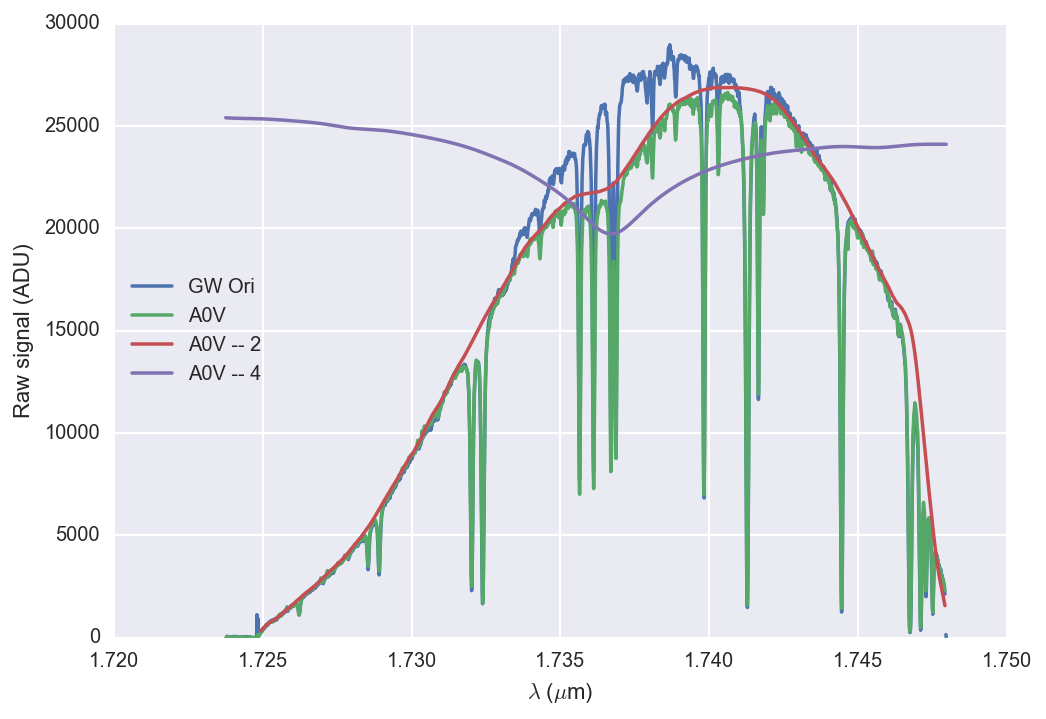

In [7]:
o=5
plt.plot(hdu_tar[1].data[o, :], hdu_tar[0].data[o, :], label='GW Ori')
plt.plot(hdu_raw[1].data[o, :], hdu_raw[0].data[o, :], label='A0V')

plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :], label='A0V -- 2')
plt.plot(hdu_f[1].data[o, :], hdu_f[4].data[o, :]/48.0, label='A0V -- 4')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");

|number|title| vector | Interpretation |
|--|--|--|--|
|0|"flattened_spec"| s_orig/continuum_array| The original A0V flux, divided by an estimate for interpolated "continuum"|
|1|"wavelength"| w|The wavelength in micrometer|
|2|"fitted_continuum"| continuum_array|The estimated, interpolated continuum, fitted by avoiding telluric lines.|
|3|"mask"| mask_array|A mask array: 0 if pixels used in continuum estimation, 1 if pixels contain telluric absorption|
|4|"a0v_norm"| a0v_array| A model Vega spectrum (broad H lines) sampled at the IGRINS pixels-- no RV or vsini convolution|
|5|"model_teltrans"| teltrans_array| A forward model of Earth's atmospheric absorption sampled at IGRINS pixels |

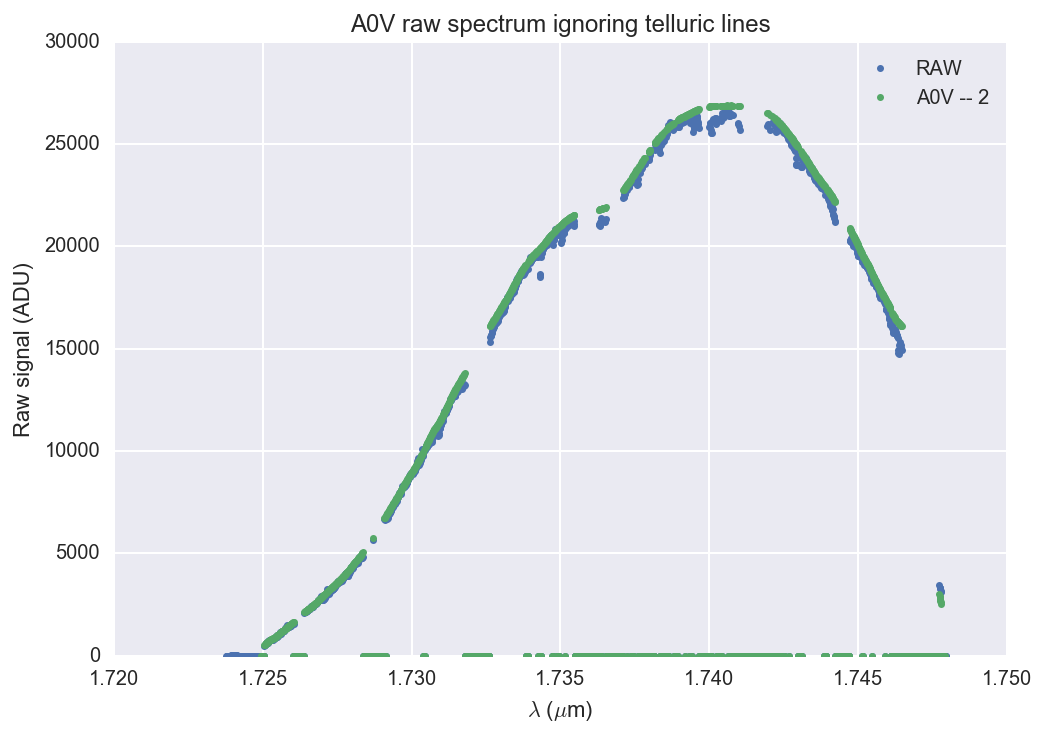

In [8]:
o=5
plt.plot(hdu_tar[1].data[o, :], hdu_raw[0].data[o, :]*(1-hdu_f[3].data[o, :]), '.', label='RAW')
#plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :], label='A0V -- 2')
plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :]*(1-hdu_f[3].data[o, :]), '.',label='A0V -- 2')
#plt.plot(hdu_f[1].data[o, :], hdu_f[5].data[o, :], label='A0V -- 5')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('A0V raw spectrum ignoring telluric lines')

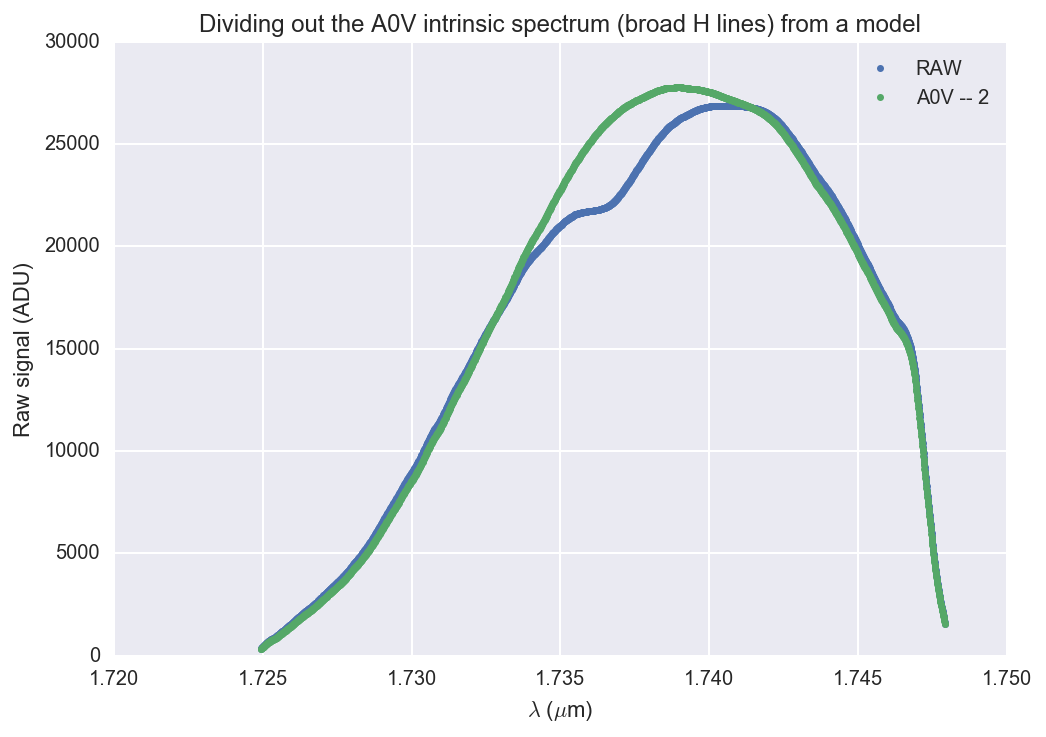

In [9]:
o=5
plt.plot(hdu_tar[1].data[o, :], hdu_f[2].data[o, :], '.', label='RAW')
#plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :], label='A0V -- 2')
plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :]/(hdu_f[4].data[o, :]/np.nanmean(hdu_f[4].data[o, :])), '.',label='A0V -- 2')
#plt.plot(hdu_f[1].data[o, :], hdu_f[5].data[o, :], label='A0V -- 5')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('Dividing out the A0V intrinsic spectrum (broad H lines) from a model');

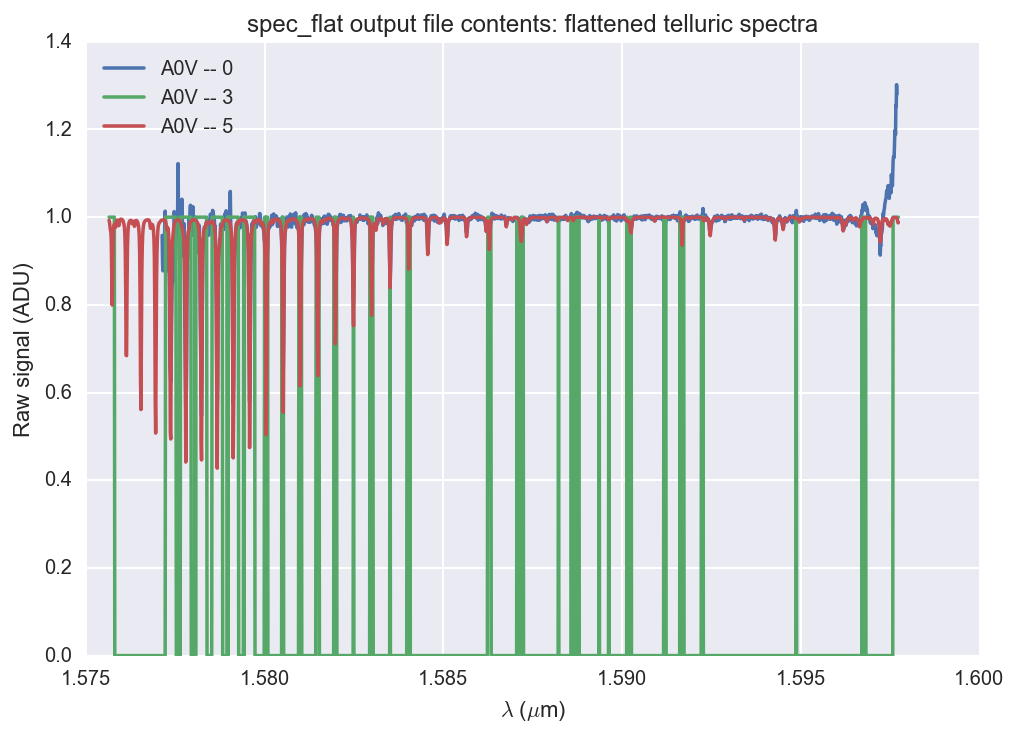

In [10]:
o=15
#plt.plot(hdu_tar[1].data[o, :], hdu_tar[1].data[o, :], label='GW Ori')
plt.plot(hdu_f[1].data[o, :], hdu_f[0].data[o, :], label='A0V -- 0')
#plt.plot(hdu_f[1].data[o, :], hdu_f[2].data[o, :], label='A0V -- 2')
plt.plot(hdu_f[1].data[o, :], hdu_f[3].data[o, :], label='A0V -- 3')
#plt.plot(hdu_f[1].data[o, :], hdu_f[4].data[o, :], label='A0V -- 4')
plt.plot(hdu_f[1].data[o, :], hdu_f[5].data[o, :], label='A0V -- 5')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('spec_flat output file contents: flattened telluric spectra');

## Revised calibration

So the main problem with the telluric correction we performed above is that it divides by the raw A0V spectrum, *without* multiplying back by the A0V model.

What we *want* to do is:  
$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} \times \hat{f}_{std}$$

Where $\hat{f}_{std}$ is the model for the A0V star.

The net uncertainty is then given by:

$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 } \times \hat{f}_{std}$$

The problem with this approach is that $\hat{f}_{std}$ is an imperfect model of ${f}_{std}$.  
Here are the ways $\hat{f}_{std}$ can be imperfect:
- Finite $v_z$ of the observed A0V standard, causes over-under corrections in spectral shape
- Finite $v\sin{i}$ of the observed A0V standard, causes over-under corrections in spectral shape

In [11]:
sns.set_context('talk')

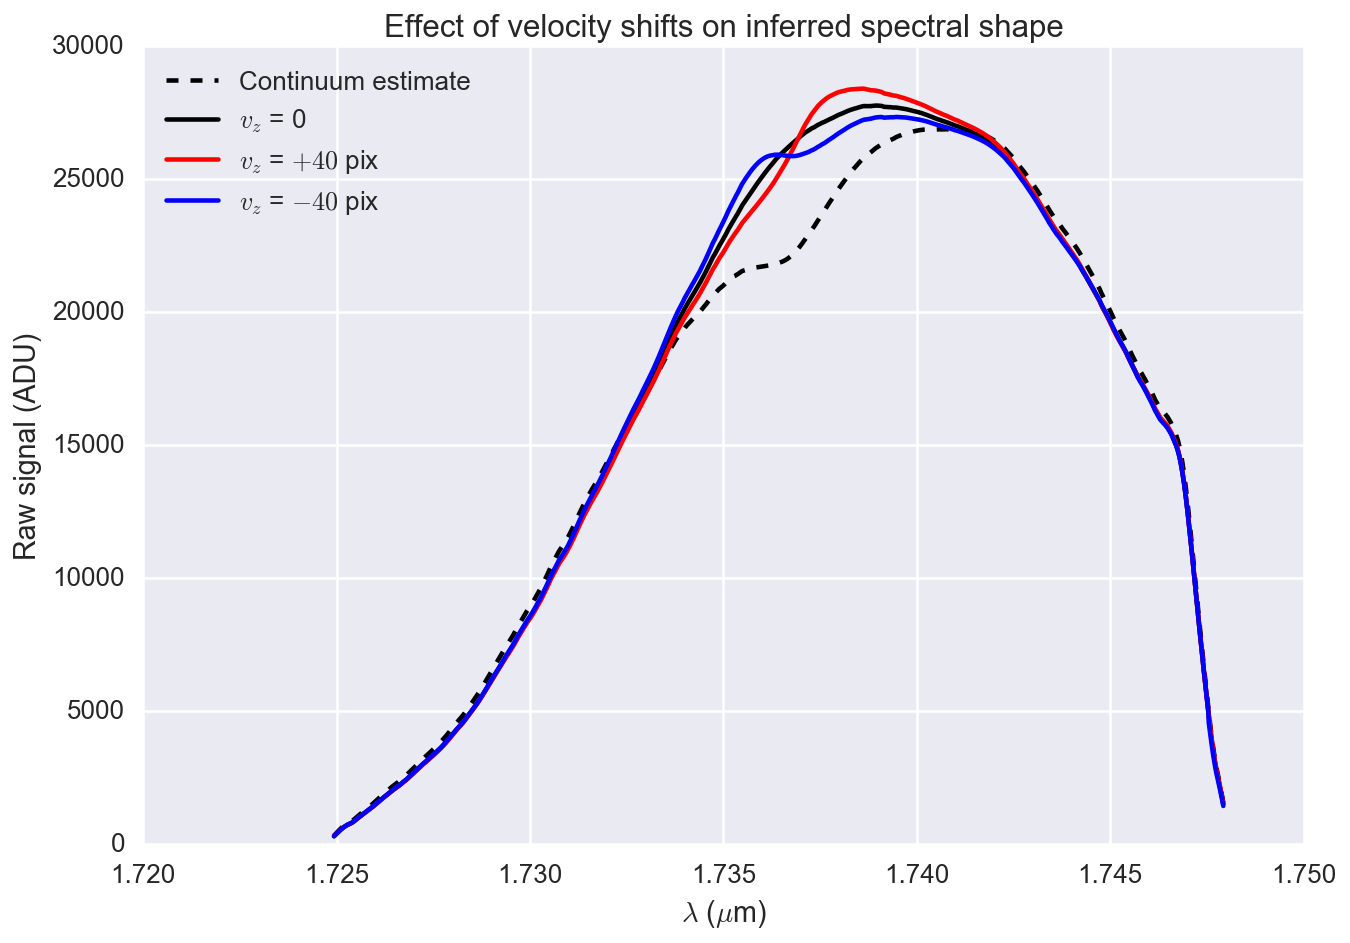

In [12]:
o=5
x = hdu_f[1].data[o, :]
num = hdu_f[2].data[o, :]
denom = hdu_f[4].data[o, :]/np.nanmean(hdu_f[4].data[o, :])
y = num / denom

plt.plot(x, hdu_f[2].data[o, :], 'k--', label='Continuum estimate')

plt.plot(x, y, 'k-',label='$v_z$ = 0')
plt.plot(x, num/np.roll(denom, 40), 'r-',label='$v_z$ = $+40$ pix')
plt.plot(x, num/np.roll(denom, -40), 'b-',label='$v_z$ = $-40$ pix')


plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('Effect of velocity shifts on inferred spectral shape')
plt.savefig('../results/vz_shift.png', dpi=300)

In [13]:
import astropy.constants as C

In [14]:
import astropy.units as u

How much of a velocity shift is required to cause 40 pixel movement?

In [15]:
(x[0]-x[40])/x[20]*C.c.to(u.km/u.s)

<Quantity -92.61587777165708 km / s>

In [16]:
Earth_rot = (C.R_earth*2.0*np.pi/(24.0*u.hour)).to(u.km/u.s)
Earth_orbit = (u.AU*2.0*np.pi/(365.25*u.day)).to(u.km/u.s)

In [17]:
Earth_rot

<Quantity 0.46383113891658767 km / s>

In [18]:
Earth_orbit

<Quantity 29.785254365591538 km / s>

The Earth's orbital motion is the most significant contributor to recessional velocity variations, but the star will also have its own galacto-centric motion and random motion, so 40 pixels recessional velocity seems plausible.

So we should probably correct the recessional velocity of the observed A0V star to better estimate $\hat{f}_{std}$, otherwise we could get weird high-frequency wiggles in our spectral shape.  What about $v\sin{i}$?

In [19]:
from astroML.linear_model import NadarayaWatson

In [20]:
nw = NadarayaWatson(h=0.0005)
nw2 = NadarayaWatson(h=0.001)

In [21]:
(0.001/1.73*C.c).to(u.km/u.s)

<Quantity 173.29043815028905 km / s>

This is the bandwidth... seems high, but need to convert to vsini.  Vega has vsini of ~20.

In [22]:
X = x[:, np.newaxis]

In [23]:
nw.fit(X, denom, dy=denom*0.03)
nw2.fit(X, denom, dy=denom*0.03)

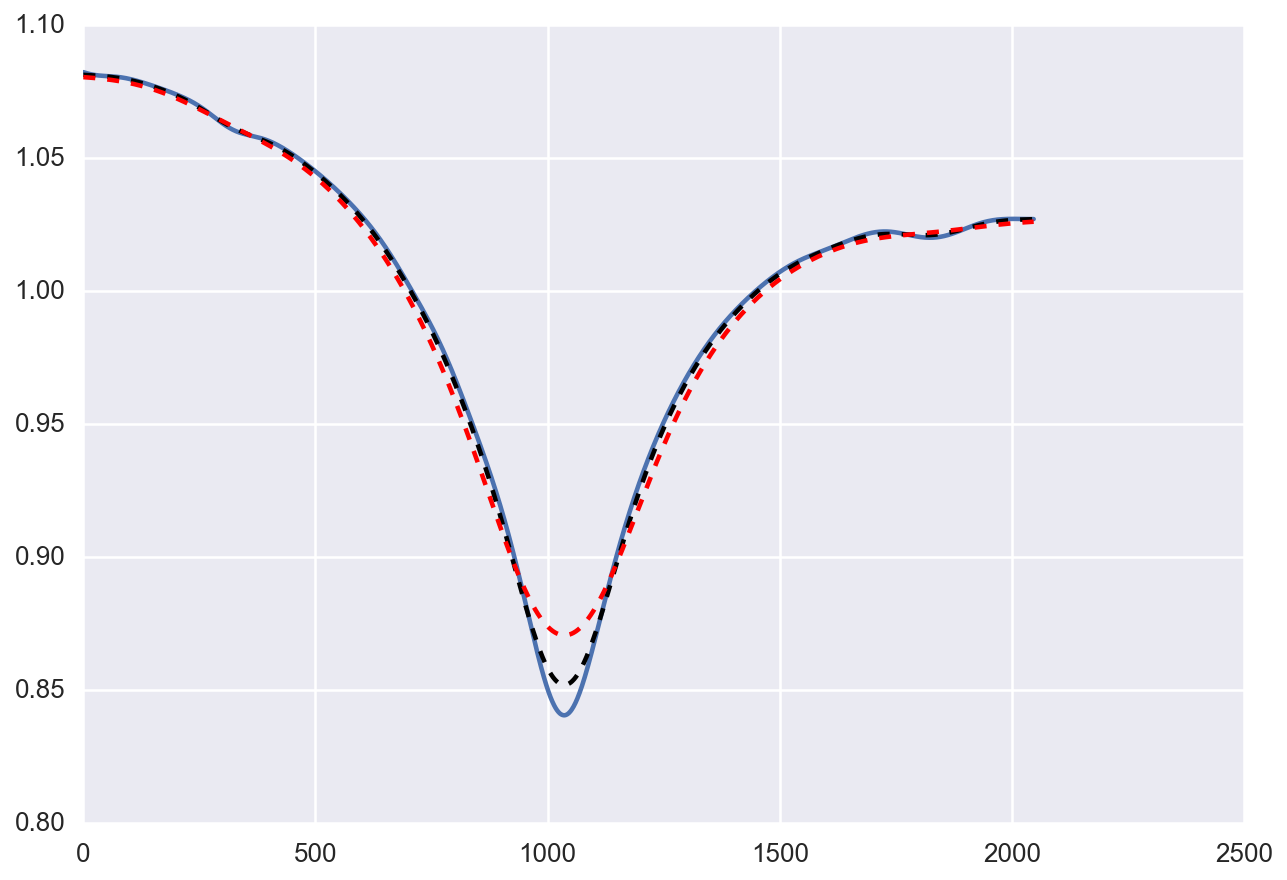

In [24]:
plt.plot(denom)
plt.plot(nw.predict(X), 'k--')
plt.plot(nw2.predict(X), 'r--')

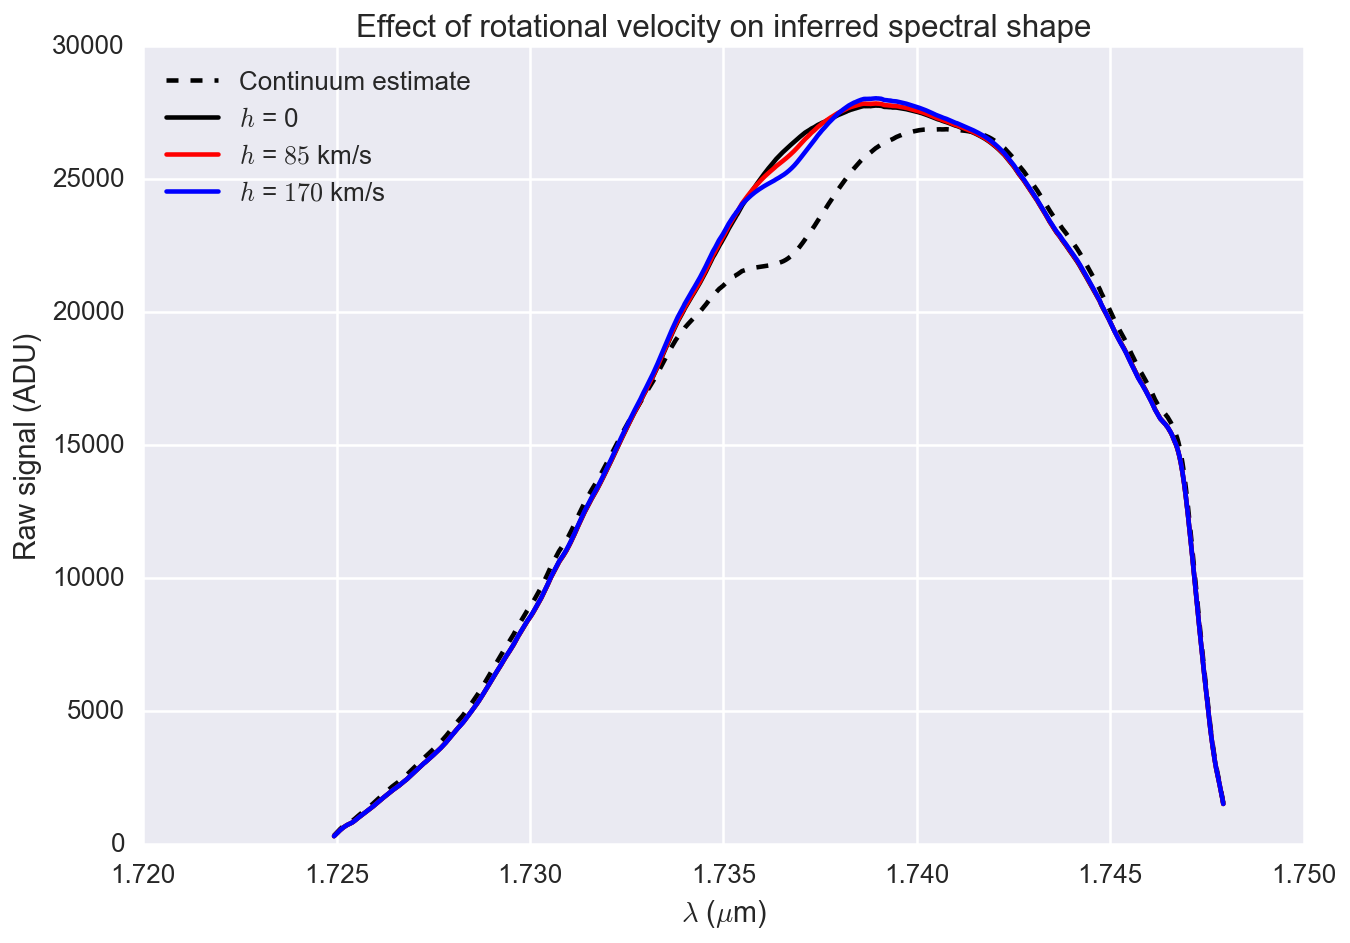

In [25]:
o=5
x = hdu_f[1].data[o, :]
num = hdu_f[2].data[o, :]
denom = hdu_f[4].data[o, :]/np.nanmean(hdu_f[4].data[o, :])
y = num / denom

plt.plot(x, hdu_f[2].data[o, :], 'k--', label='Continuum estimate')

plt.plot(x, y, 'k-',label='$h$ = 0')
plt.plot(x, num/nw.predict(X), 'r-',label='$h$ = $85$ km/s')
plt.plot(x, num/nw2.predict(X), 'b-',label='$h$ = $170$ km/s')


plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.title('Effect of rotational velocity on inferred spectral shape')
plt.savefig('../results/vsini_shift.png', dpi=300)

So there's a small bump that could arise from stars with vsini > 20 km/s (Vega's vsini).  If the star had vsini < 20 km/s, the bump would go the other direction.

### Results

Well, it's still better to correct the spectral shape that to do *nothing*, but it's better to correct the model for the observed A0V star, if possible.